<a href="https://colab.research.google.com/github/bimarshak7/yoga-pose-classification/blob/main/yoga_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#snippet to mount drive and copy kaggle API keys
from google.colab import drive
drive.mount('/gdrive')
! mkdir ~/.kaggle
!cp "/gdrive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /gdrive


In [ ]:
  !kaggle datasets download -d shrutisaxena/yoga-pose-image-classification-dataset
  !unzip -q yoga-pose-image-classification-dataset.zip

 98% 985M/0.98G [00:08<00:00, 92.8MB/s]
100% 0.98G/0.98G [00:08<00:00, 126MB/s]


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
#check tensorflow version
print(tf.__version__)

2.9.2


In [ ]:
!ls

dataset  sample_data  yoga-pose-image-classification-dataset.zip


In [ ]:
import os

for root, dirs, files in os.walk("dataset"):
  print(f"There are {len(files)} images in '{root}'.")

There are 0 images in 'dataset'.
There are 56 images in 'dataset/paschimottanasana'.
There are 38 images in 'dataset/utthita ashwa sanchalanasana'.
There are 40 images in 'dataset/ardha bhekasana'.
There are 69 images in 'dataset/utthita trikonasana'.
There are 40 images in 'dataset/kurmasana'.
There are 35 images in 'dataset/pincha mayurasana'.
There are 67 images in 'dataset/salamba sarvangasana'.
There are 39 images in 'dataset/durvasasana'.
There are 35 images in 'dataset/hanumanasana'.
There are 72 images in 'dataset/astavakrasana'.
There are 71 images in 'dataset/supta baddha konasana'.
There are 51 images in 'dataset/eka pada koundinyanasana i'.
There are 56 images in 'dataset/virabhadrasana ii'.
There are 36 images in 'dataset/lolasana'.
There are 61 images in 'dataset/virabhadrasana iii'.
There are 63 images in 'dataset/urdhva mukha svanasana'.
There are 54 images in 'dataset/bharadvajasana i'.
There are 64 images in 'dataset/anjaneyasana'.
There are 57 images in 'dataset/maka

No. of classes = 107
Total no. of images 5994
Size of random image: (148, 334, 3)


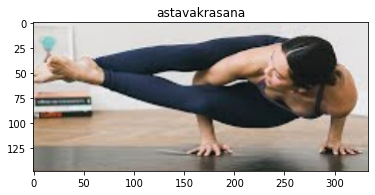

In [ ]:
# Get the classnames programmatically
import pathlib
dataset_dir = "dataset"
data_dir = pathlib.Path(dataset_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
image_list = np.array(list(data_dir.glob('*/*')))
rand_path = str(image_list[np.random.randint(1,500)])
sample_image = tf.io.read_file(rand_path)
sample_tensor = tf.io.decode_image(sample_image, channels=3, dtype=tf.dtypes.float32)

print(f"No. of classes = {len(class_names)}")
print(f"Total no. of images",len(image_list))
print(f"Size of random image:",sample_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(sample_tensor)
plt.title(rand_path.split("/")[-2])
plt.show()

In [ ]:
batch_size = 32
img_height = 300
img_width = 300
num_classes = len(class_names)
num_classes

107

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2, 
  subset="training",
  seed=24,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5993 files belonging to 107 classes.
Using 4795 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5993 files belonging to 107 classes.
Using 1198 files for validation.


In [ ]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2,0.2)
])

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
aug_ds = train_ds.take(10).map(
  lambda x, y: (data_augment(x, training=True), y))

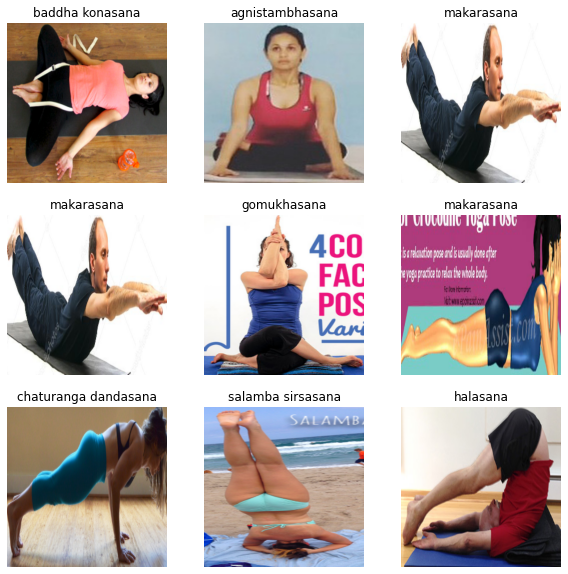

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand_num = np.random.randint(0,31)
    plt.imshow(images[rand_num].numpy().astype("uint8"))
    plt.title(class_names[labels[rand_num]])
    plt.axis("off")

In [ ]:
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
final_ds = train_ds.concatenate(aug_ds)
final_ds.shuffle(6000)

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(num_classes)
])

model1.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
150/150 [==============================] - 25s 159ms/step - loss: 0.1221 - accuracy: 0.9796 - val_loss: 0.8382 - val_accuracy: 0.8631
Epoch 2/30
150/150 [==============================] - 25s 160ms/step - loss: 0.1343 - accuracy: 0.9789 - val_loss: 0.7153 - val_accuracy: 0.8715
Epoch 3/30
150/150 [==============================] - 24s 158ms/step - loss: 0.1340 - accuracy: 0.9725 - val_loss: 0.8125 - val_accuracy: 0.8673
Epoch 4/30
150/150 [==============================] - 25s 160ms/step - loss: 0.1586 - accuracy: 0.9766 - val_loss: 0.7844 - val_accuracy: 0.8715
Epoch 5/30
150/150 [==============================] - 25s 159ms/step - loss: 0.1428 - accuracy: 0.9769 - val_loss: 0.7764 - val_accuracy: 0.8664
Epoch 6/30
150/150 [==============================] - 25s 159ms/step - loss: 0.1423 - accuracy: 0.9779 - val_loss: 0.7175 - val_accuracy: 0.8698
Epoch 7/30
150/150 [==============================] - 26s 168ms/step - loss: 0.1353 - accuracy: 0.9779 - val_loss: 0.7489 - val_ac

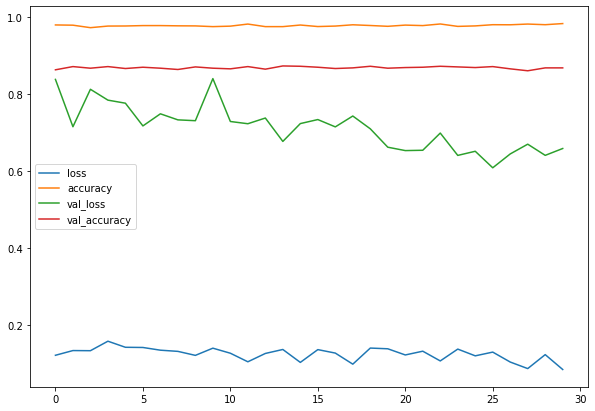

In [ ]:
import pandas as pd
pd.DataFrame(history1.history).plot(figsize=(10, 7));

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(num_classes)
])

model2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
150/150 [==============================] - 24s 157ms/step - loss: 2.8722 - accuracy: 0.3458 - val_loss: 3.1766 - val_accuracy: 0.3898
Epoch 2/100
150/150 [==============================] - 24s 156ms/step - loss: 2.7841 - accuracy: 0.3583 - val_loss: 3.0833 - val_accuracy: 0.3948
Epoch 3/100
150/150 [==============================] - 24s 157ms/step - loss: 2.6981 - accuracy: 0.3773 - val_loss: 2.9996 - val_accuracy: 0.4157
Epoch 4/100
150/150 [==============================] - 24s 156ms/step - loss: 2.6354 - accuracy: 0.3923 - val_loss: 2.9454 - val_accuracy: 0.4257
Epoch 5/100
150/150 [==============================] - 24s 157ms/step - loss: 2.5383 - accuracy: 0.4008 - val_loss: 2.8521 - val_accuracy: 0.4424
Epoch 6/100
150/150 [==============================] - 24s 156ms/step - loss: 2.4851 - accuracy: 0.4175 - val_loss: 2.7726 - val_accuracy: 0.4558
Epoch 7/100
150/150 [==============================] - 24s 158ms/step - loss: 2.4032 - accuracy: 0.4334 - val_loss: 2.7050 -

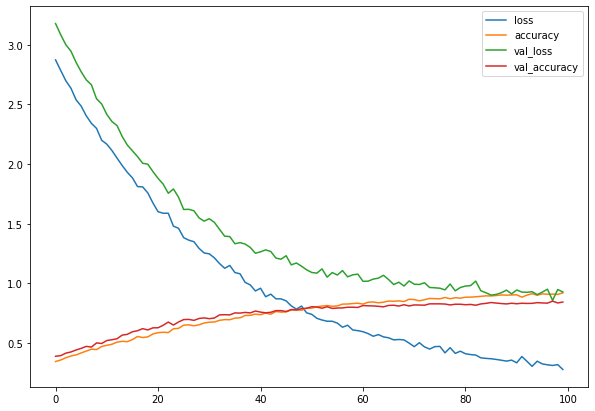

In [ ]:
import pandas as pd
pd.DataFrame(history2.history).plot(figsize=(10, 7));

In [ ]:
model3 = tf.keras.Sequential([
  data_augment,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(num_classes)
])

model3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.00001(too slow to converge) to 0.001
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
150/150 [==============================] - 41s 271ms/step - loss: 4.6421 - accuracy: 0.0156 - val_loss: 4.6487 - val_accuracy: 0.0150
Epoch 2/30
150/150 [==============================] - 28s 179ms/step - loss: 4.6421 - accuracy: 0.0156 - val_loss: 4.6487 - val_accuracy: 0.0150
Epoch 3/30
150/150 [==============================] - 30s 192ms/step - loss: 4.6422 - accuracy: 0.0156 - val_loss: 4.6487 - val_accuracy: 0.0150
Epoch 4/30
150/150 [==============================] - 28s 181ms/step - loss: 4.6422 - accuracy: 0.0156 - val_loss: 4.6487 - val_accuracy: 0.0150
Epoch 5/30
150/150 [==============================] - 28s 178ms/step - loss: 4.6421 - accuracy: 0.0156 - val_loss: 4.6488 - val_accuracy: 0.0150
Epoch 6/30
150/150 [==============================] - 27s 177ms/step - loss: 4.6421 - accuracy: 0.0156 - val_loss: 4.6488 - val_accuracy: 0.0150
Epoch 7/30
150/150 [==============================] - 28s 179ms/step - loss: 4.6421 - accuracy: 0.0156 - val_loss: 4.6488 - val_ac

augmentation didn't help

In [ ]:
model4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(num_classes)
])

model4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.00001(too slow to converge) to 0.001
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200
)

Epoch 1/200
150/150 [==============================] - 30s 195ms/step - loss: 0.4809 - accuracy: 0.8580 - val_loss: 0.7028 - val_accuracy: 0.8715
Epoch 2/200
150/150 [==============================] - 30s 193ms/step - loss: 0.4420 - accuracy: 0.8640 - val_loss: 0.7269 - val_accuracy: 0.8706
Epoch 3/200
150/150 [==============================] - 30s 194ms/step - loss: 0.4453 - accuracy: 0.8636 - val_loss: 0.6650 - val_accuracy: 0.8748
Epoch 4/200
150/150 [==============================] - 30s 196ms/step - loss: 0.4615 - accuracy: 0.8624 - val_loss: 0.7094 - val_accuracy: 0.8806
Epoch 5/200
150/150 [==============================] - 31s 204ms/step - loss: 0.4521 - accuracy: 0.8599 - val_loss: 0.7953 - val_accuracy: 0.8656
Epoch 6/200
150/150 [==============================] - 30s 196ms/step - loss: 0.4461 - accuracy: 0.8674 - val_loss: 0.6021 - val_accuracy: 0.8715
Epoch 7/200
150/150 [==============================] - 30s 195ms/step - loss: 0.4229 - accuracy: 0.8688 - val_loss: 0.5963 -